In [1]:
# Import necessary libraries
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("fashion_products.csv")
data.head()


,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


 Content-Based Recommendation Setup

In [2]:
# Content-Based Recommendation Setup
content_df = data[['Product ID', 'Product Name', 'Brand', 'Category', 'Color', 'Size']]
content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# Use TF-IDF vectorizer to convert content into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
content_matrix = tfidf_vectorizer.fit_transform(content_df['Content'])

# Calculate similarity matrix
content_similarity = linear_kernel(content_matrix, content_matrix)

# Function for Content-Based Recommendations
def get_content_based_recommendations(product_id, top_n=10):
    index = content_df[content_df['Product ID'] == product_id].index[0]
    similarity_scores = content_similarity[index]
    similar_indices = similarity_scores.argsort()[::-1][1:top_n + 1]
    recommendations = content_df.loc[similar_indices, 'Product ID'].values
    return recommendations


/var/folders/nt/v2bng3lj0dbdlhd2kk8_rb0c0000gn/T/ipykernel_3293/3750329346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)


Collaborative Filtering Setup

In [4]:
# Collaborative Filtering Setup
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['User ID', 'Product ID', 'Rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=0.2)
algo = SVD()
algo.fit(trainset)

# Function for Collaborative Filtering Recommendations
def get_collaborative_filtering_recommendations(user_id, top_n=10):
    testset = trainset.build_anti_testset()
    testset = filter(lambda x: x[0] == user_id, testset)
    predictions = algo.test(testset)
    predictions.sort(key=lambda x: x.est, reverse=True)
    recommendations = [prediction.iid for prediction in predictions[:top_n]]
    return recommendations


Hybrid Recommendation Function

In [5]:
# Hybrid Recommendation Function
def get_hybrid_recommendations(user_id, product_id, top_n=10):
    content_recs = get_content_based_recommendations(product_id, top_n=top_n*2)
    collab_recs = get_collaborative_filtering_recommendations(user_id, top_n=top_n*2)

    # Combining both recommendations and taking unique ones
    combined_recs = list(set(content_recs) | set(collab_recs))
    combined_recs.sort(key=lambda x: content_recs.tolist().index(x) if x in content_recs else len(content_recs))
    
    return combined_recs[:top_n]


Performance Evaluation

In [6]:
# Performance Evaluation
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Output RMSE and MAE
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 1.2365
MAE:  1.0854
RMSE: 1.2364825096499374
MAE: 1.0853924283410832


Visualizing Ratings Distribution

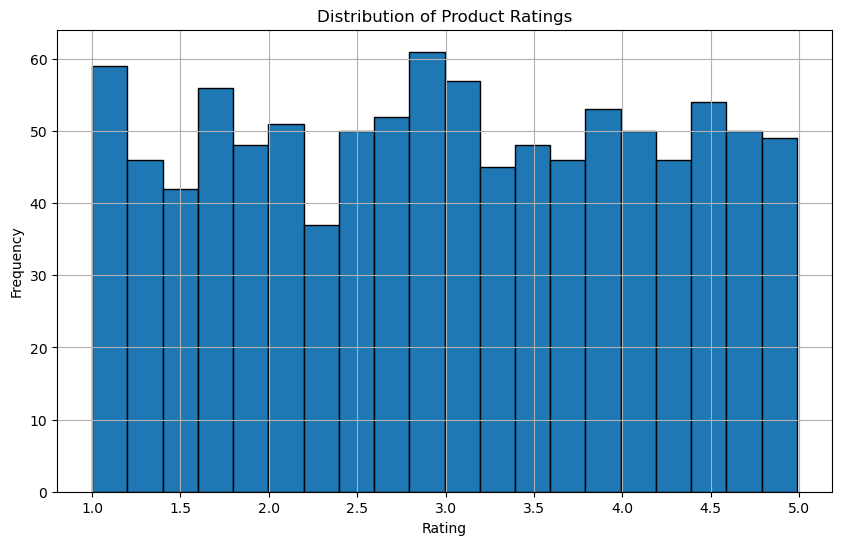

In [7]:
# Visualization of Ratings Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['Rating'], bins=20, edgecolor='black')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Hybrid Recommendations for a Specific User

In [9]:
# Display the Hybrid Recommendations for a Specific User and Product
user_id = 7
product_id = 12
top_n = 10
recommendations = get_hybrid_recommendations(user_id, product_id, top_n)

# Output Recommendations
recommendations_display = pd.DataFrame(recommendations, columns=['Recommended Product ID'])
recommendations_display = recommendations_display.merge(content_df[['Product ID', 'Product Name', 'Brand']], 
                                                        left_on='Recommended Product ID', right_on='Product ID')
print(f"Hybrid Recommendations for User {user_id} based on Product {product_id}:")
display(recommendations_display)


Hybrid Recommendations for User 7 based on Product 12:


,Recommended Product ID,Product ID,Product Name,Brand
0,729,729,Sweater,Gucci
1,217,217,Sweater,Gucci
2,69,69,Sweater,Gucci
3,185,185,Sweater,Gucci
4,170,170,Sweater,Gucci
5,518,518,Sweater,Gucci
6,882,882,Sweater,Gucci
7,948,948,Sweater,Gucci
8,833,833,Sweater,H&M
9,445,445,Sweater,H&M
